In [1]:
import pandas as pd

## Loading DataFrames

In [2]:
old_prices = pd.read_csv("../databases/csv/2022_12_27/prices_raw2.csv", index_col=0, compression='xz')
new_prices = pd.read_csv("../databases/csv/2023_01_08/prices_raw.csv", index_col=0, compression='xz')
df_variants = pd.read_csv("../databases/csv/2023_01_08/variants_raw.csv", index_col=0, compression='xz')
df_products = pd.read_csv("../databases/csv/2023_01_08/products_raw.csv", index_col=0, compression='xz')
print(f'old_prices.shape: {old_prices.shape}')
print(f'new_prices.shape: {new_prices.shape}')

/tmp/ipykernel_104156/2726444057.py:3: DtypeWarning: Columns (5,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_variants = pd.read_csv("../databases/csv/2022_12_27/variants_raw.csv", index_col=0, compression='xz')


old_prices.shape: (33895, 11)
new_prices.shape: (32302, 11)


## Initial analysis

In [3]:
old_prices["gross"].sort_values(ascending=False).head(10)

37552    2999999
37548    2399999
37544    1149999
36226     999999
36891     938699
36221     936999
37540     879999
36771     879999
42441     839990
42437     839990
Name: gross, dtype: int64

In [4]:
new_prices["gross"].sort_values(ascending=False).head(10)

67216    2621299
67212    2399999
67207    1149999
66139     999999
66511     938699
66132     936999
71479     839990
71473     839990
71477     839990
67201     799999
Name: gross, dtype: int64

<AxesSubplot: >

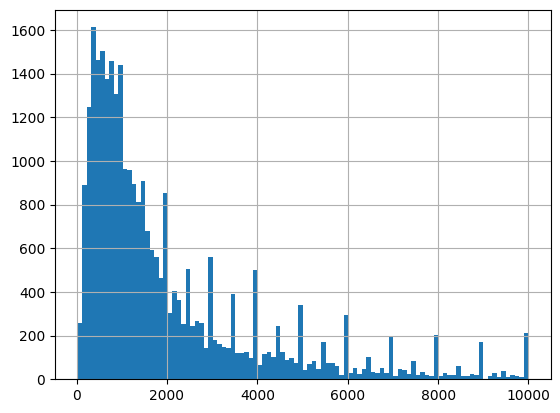

In [5]:
old_prices.loc[old_prices["gross"] < 10001, "gross"].hist(bins=100)

<AxesSubplot: >

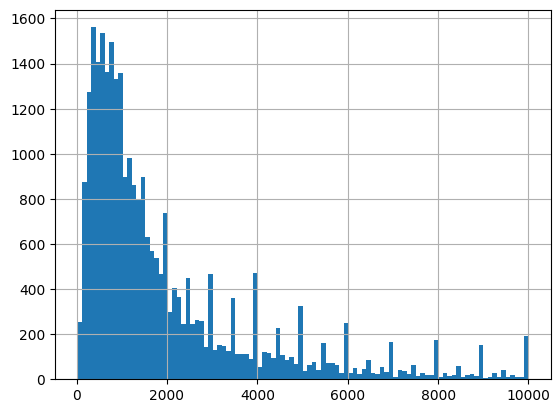

In [6]:
new_prices.loc[new_prices["gross"] < 10001, "gross"].hist(bins=100)

In [7]:
pd.options.display.float_format = '{:.2f}'.format

In [8]:
old_prices["gross"].describe(percentiles=[.1, .15, .2, .25, .35, .5, .75, .9])

count     33895.00
mean      10143.96
std       46191.03
min          20.00
10%         389.00
15%         499.00
20%         599.00
25%         719.00
35%         999.00
50%        1499.00
75%        3999.00
90%       13990.00
max     2999999.00
Name: gross, dtype: float64

In [9]:
new_prices["gross"].describe(percentiles=[.1, .15, .2, .25, .35, .5, .75, .9])

count     32302.00
mean       9785.87
std       45561.77
min          20.00
10%         375.00
15%         489.00
20%         599.00
25%         699.00
35%         939.00
50%        1439.00
75%        3850.00
90%       12490.00
max     2621299.00
Name: gross, dtype: float64

## Merging old and new prices with variants and products

In [24]:
# merge the two dataframes on id where gross is not the same
merged = pd.merge(old_prices, new_prices, on="id", suffixes=("_old", "_new"), how="outer", indicator=True)
merged = merged.loc[merged["_merge"] == "both"]
merged = merged.loc[merged["gross_old"] != merged["gross_new"]]
# merge variants on id
merged = pd.merge(merged, df_variants, on="id", how="left")
merged = pd.merge(merged, df_products, left_on="productId", right_on="id", how="left")

In [25]:
merged[["name", "gross_old", "gross_new"]]

,name,gross_old,gross_new
0,DeLonghi DLSC551 víztisztító golyók,2999.00,3599.00
1,Aspico 312102 univerzális kávékiöntő,3399.00,2899.00
2,DeLonghi Pohár szett,3879.00,4349.00
3,Aspico 312105 univerzális kávékiöntő,4199.00,3899.00
4,Aspico 312106 univerzális kávékiöntő,5199.00,4399.00
...,...,...,...
4171,Mesekönyv: Esti mesék gyerekeknek,1890.00,1990.00
4172,Marék Veronika : Boribon karácsonya,1990.00,2490.00
4173,J. K. Rowling: A karácsonyi malac,3990.00,4890.00
4174,BELLA BABY HAPPY PELENKÁZÓ ALÁTÉT 90X60 CM 5 DB,1299.00,1099.00


In [26]:
merged.loc[merged["gross_old"] < merged["gross_new"], ["name", "gross_old", "gross_new"]]

,name,gross_old,gross_new
0,DeLonghi DLSC551 víztisztító golyók,2999.00,3599.00
2,DeLonghi Pohár szett,3879.00,4349.00
5,Selecline 150178 palacsintasütő,7999.00,10799.00
6,Christina Braun: Nyírd ki csajosan,1990.00,2599.00
7,Keri Smith: Nyírd ki ezt a naplót,1990.00,2599.00
...,...,...,...
4169,Varázstoll - Karácsony,1690.00,1990.00
4170,Duck Egg Blue: Téli történetek: simogasd meg -...,890.00,990.00
4171,Mesekönyv: Esti mesék gyerekeknek,1890.00,1990.00
4172,Marék Veronika : Boribon karácsonya,1990.00,2490.00


## Calculating the price change

In [27]:
# percent change by each row
merged["percent_change"] = ((merged["gross_new"] - merged["gross_old"]) / merged["gross_old"])*100
merged["discounted_percent_change"] = ((merged["grossDiscounted_new"] - merged["grossDiscounted_old"]) / merged["grossDiscounted_old"])*100

In [28]:
merged[['name', 'gross_old', 'gross_new', 'percent_change', 'isDiscounted_old', 'isDiscounted_new', 'grossDiscounted_old', 'grossDiscounted_new']].sort_values(by="percent_change", ascending=False)

,name,gross_old,gross_new,percent_change,isDiscounted_old,isDiscounted_new,grossDiscounted_old,grossDiscounted_new
3614,Na! Na! Na! Surprise Sweetest Hearts Baba,3000.00,9990.00,233.00,False,False,3000.00,9990.00
3609,One2Fun lószállító autó,5000.00,14990.00,199.80,False,False,5000.00,14990.00
3886,Babatex-40 Special Edition,1500.00,4109.00,173.93,False,True,1500.00,1500.00
3660,One2Fun távirányítós autó 1:24 (többféle),2000.00,4990.00,149.50,False,False,2000.00,4990.00
2380,"Martini Asti illatos minőségi édes pezsgő 7,5%...",2499.00,4739.00,89.64,False,False,2499.00,4739.00
...,...,...,...,...,...,...,...,...
186,Univer Erős Pistás szaloncukor minőségi belga ...,1110.00,300.00,-72.97,False,False,1110.00,300.00
446,Halloween szemek tasakban 15g,399.00,100.00,-74.94,False,False,399.00,100.00
1100,Marlenka mézes tekercs áfonyával 300 g,3999.00,799.00,-80.02,False,False,3999.00,799.00
1097,Marlenka mézes kakaós tekercs málnával 300 g,3999.00,799.00,-80.02,False,False,3999.00,799.00


In [29]:
merged["isDiscounted_old"].value_counts()

False    3898
True      278
Name: isDiscounted_old, dtype: int64

## Analyzing the price of condoms

In [30]:
merged.loc[merged["name"].str.contains("óvszer"), ["name", "percent_change", "discounted_percent_change", "gross_old", "grossDiscounted_old", "gross_new", "grossDiscounted_new", "categoryName"]].sort_values(by="percent_change", ascending=False)

,name,percent_change,discounted_percent_change,gross_old,grossDiscounted_old,gross_new,grossDiscounted_new,categoryName
1667,Durex extra safe óvszer 18 db,19.78,19.78,4499.00,4499.00,5389.00,5389.00,Szexuális jólét
1588,Masculan Gold Luxury Edition óvszer 10 db,12.19,72.66,1559.00,1013.00,1749.00,1749.00,Szexuális jólét
1592,Masculan Pur leheletvékony síkosítóval és ondó...,12.19,72.66,1559.00,1013.00,1749.00,1749.00,Szexuális jólét
1597,Masculan Anatomic anatómiailag formált síkosít...,10.26,47.05,1559.00,1169.00,1719.00,1719.00,Szexuális jólét
1603,Masculan Sensitive szuper vékony síkosítóval e...,10.26,47.05,1559.00,1169.00,1719.00,1719.00,Szexuális jólét
1632,"LifeStyles Ultra Thin spermazsákkal ellátott, ...",7.65,7.65,3399.00,3399.00,3659.00,3659.00,Szexuális jólét
1659,Durex Feel Ultra Thin óvszer 10 db,5.26,5.26,3799.00,3799.00,3999.00,3999.00,Szexuális jólét
1658,Durex Feel Thin óvszer 12 db,5.26,5.26,3799.00,3799.00,3999.00,3999.00,Szexuális jólét
1651,Durex Feel Intimate óvszer 12 db,5.26,5.26,3799.00,3799.00,3999.00,3999.00,Szexuális jólét
1672,Durex Intense óvszer 10 db,4.35,4.35,4599.00,4599.00,4799.00,4799.00,Szexuális jólét


## Analyzing prices by categories

In [19]:
merged_prod = merged[
    ['name', 'gross_old', 'grossDiscounted_old', 'gross_new', 'grossDiscounted_new', 'percent_change', 'discounted_percent_change', 'categoryName']
]

### Negative price changes

In [20]:
merged_prod.loc[merged_prod["discounted_percent_change"] < 0, "categoryName"].value_counts()

Szaloncukor                     31
Beépíthető főzőlap              27
Fülhallgató                     22
Tejcsokoládé ízesített          21
Törölköző                       19
                                ..
Köretek, gabonák, hüvelyesek     1
Étrendkiegészítők                1
Fagyasztott hamburger            1
Kávé, tea, kakaó                 1
Játszócumik                      1
Name: categoryName, Length: 410, dtype: int64

### Positive price changes

In [21]:
merged_prod.loc[merged_prod["discounted_percent_change"] > 0, "categoryName"].value_counts()

Gyermekkönyvek                       61
Sampon                               60
Fogkrém                              54
Testápolás                           50
Száraz vörös borok                   40
                                     ..
Fagyasztott mono zöldség              1
Fagyasztott hasábburgonya             1
Fagyasztott gomba és gombakeverék     1
Gesztenyepüré, gesztenye              1
Légfrissítők                          1
Name: categoryName, Length: 541, dtype: int64

In [22]:
merged_prod.loc[merged["categoryName"] == "Okostelefon", ["name", "percent_change", "discounted_percent_change", "gross_old", "grossDiscounted_old", "gross_new", "grossDiscounted_new", "categoryName"]].sort_values(by="discounted_percent_change")

,name,percent_change,discounted_percent_change,gross_old,grossDiscounted_old,gross_new,grossDiscounted_new,categoryName
4381,Xiaomi Redmi 9AT Aurora Green 2/32 GB MZB0A3IE...,-16.14,-16.14,61999.00,61999.00,51990.00,51990.00,Okostelefon
4412,Samsung Galaxy A52 DS 6GB/128GB kék okostelefon,-7.69,-7.69,129990.00,129990.00,119999.00,119999.00,Okostelefon
4392,"Samsung A135F GALAXY A13 DS 64GB, BLACK telefon",-2.77,-2.77,71990.00,71990.00,69999.00,69999.00,Okostelefon
4269,"Samsung A135F GALAXY A13 DS 64GB, WHITE telefon",-2.77,-2.77,71990.00,71990.00,69999.00,69999.00,Okostelefon
4430,Xiaomi Redmi Note 11 PRO 5G Polar White 6/128 ...,-2.63,-2.63,189989.00,189989.00,184999.00,184999.00,Okostelefon
...,...,...,...,...,...,...,...,...
4395,Huawei P30 Lite Dual SIM 128GB pávakék okostel...,NaN,NaN,79989.00,79989.00,NaN,NaN,Okostelefon
4408,Huawei Nova 5T DS 128GB lila okostelefon,NaN,NaN,109990.00,109990.00,NaN,NaN,Okostelefon
4413,Oppo Reno5 Z 5G DS 8GB+128GB kék okostelefon,NaN,NaN,142999.00,142999.00,NaN,NaN,Okostelefon
4415,Xiaomi Redmi Note 11S Pearl White 6/128 GB kár...,NaN,NaN,149989.00,149989.00,NaN,NaN,Okostelefon
